# TP1

Importamos las librerias necesarias.

In [140]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2
from scipy.stats import kstest
from scipy.stats import distributions

Generador de enteros de 32 bits de periodo 2^128 - 1. Debido a que Python no tiene el problema de desbordamiento de enteros, limitamos la operación para números de 32 bits.

In [3]:
class XORSHIFT128:
    def __init__(self, x, y, z, w):
        self.periodo = 2**128 - 1
        self.x = x
        self.y = y
        self.z = z
        self.w = w

    def rnd(self):
        tmp = (self.x^(self.x<<11)) & 0xFFFFFFFF # Resultado en 32 bits
        self.x=self.y
        self.y=self.z
        self.z=self.w
        self.w = (self.w ^ (self.w >> 19)) ^ (tmp ^ (tmp >> 8)) & 0xFFFFFFFF # Resultado en 32 bits
        return self.w
        
    def rnd_cero_uno(self):
        return self.rnd()/(2**32 - 1)
    
    def muestra_cero_uno(self, n):
        muestra = []
        for _ in range(n):
            muestra.append(self.rnd_cero_uno())
        return muestra

generador = XORSHIFT128(123456789, 362436069, 521288629, 88675123)
for _ in range(5):
    numero_generado = generador.rnd()
    print(numero_generado, type(numero_generado))

3701687786 <class 'int'>
458299110 <class 'int'>
2500872618 <class 'int'>
3633119408 <class 'int'>
516391518 <class 'int'>


Para generar números aleatorios entre 0 y 1 debemos dividir entre el numero maximo. Para resolver este ítem se implementó el método rnd_cero_uno()

In [4]:
for _ in range(5):
    numero_generado = generador.rnd_cero_uno()
    print(numero_generado)

0.5535012051820525
0.6053478875209922
0.16699309185310107
0.03209956549855405
0.09204706016277127


## Vemos que tan bueno es el generador

Primero vemos que tan bien se distribuye entre el 0 y 1.

In [5]:
observaciones = []
for _ in range(10**5):
  observaciones.append(generador.rnd_cero_uno())

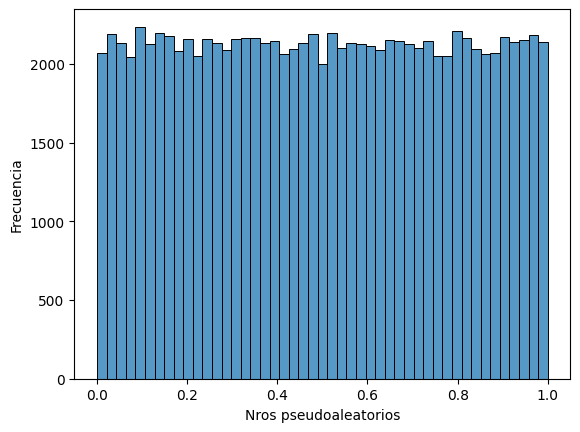

In [6]:
sns_hist=sns.histplot(data=observaciones).set(xlabel="Nros pseudoaleatorios",ylabel="Frecuencia")
plt.show()

Observamos que tiene una buena distribucion.

Ahora vemos si hay algun patrón en la distribución.

In [7]:
limit=1000
n_obs = observaciones[:limit]
n_plus_1_obs = observaciones[1:limit+1]

Vemos si hay algun patrón entre una muestra de los números generados y sus consecutivos.

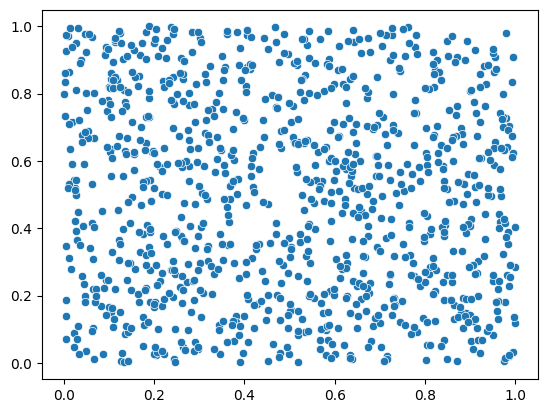

In [8]:
sns_scat=sns.scatterplot(x=n_obs, y=n_plus_1_obs)
plt.show()

Vemos que los puntos no muestran ningún patrón a simple vista.

Para generar números aleatorios entre 0 y 1 debemos dividir entre el numero maximo. Para resolver este ítem se implementó el método rnd_cero_uno()

In [9]:
for _ in range(5):
    numero_generado = generador.rnd_cero_uno()
    print(numero_generado)

0.2887586770320215
0.3308655222251233
0.4752988942142806
0.23853036208044048
0.07959818795314016


## Vemos que tan bueno es el generador

Primero vemos que tan bien se distribuye entre el 0 y 1.

In [10]:
observaciones = []
for _ in range(10**5):
  observaciones.append(generador.rnd_cero_uno())

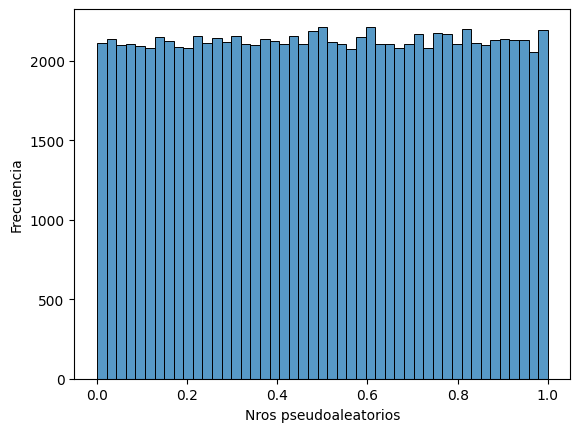

In [11]:
sns_hist=sns.histplot(data=observaciones).set(xlabel="Nros pseudoaleatorios",ylabel="Frecuencia")
plt.show()

Observamos que tiene una buena distribucion.

Ahora vemos si hay algun patrón en la distribución.

In [12]:
limit=1000
n_obs = observaciones[:limit]
n_plus_1_obs = observaciones[1:limit+1]

Vemos si hay algun patrón entre una muestra de los números generados y sus consecutivos.

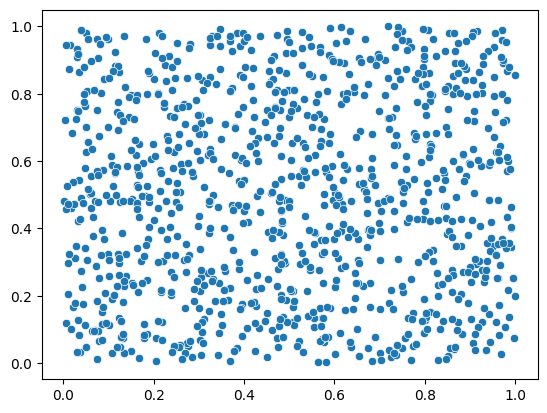

In [13]:
sns_scat=sns.scatterplot(x=n_obs, y=n_plus_1_obs)
plt.show()

Vemos que los puntos no muestran ningún patrón a simple vista.

## Ejercicio 2

Los tests que utilizaremos son:
* Test de frecuencia (Discretización + Chi²)
* Test de Kolmogorov-Smirnov
* Test QQ Plot

Para cada uno de estos tests, utilizaremos muestras de los siguientes tamaños: 100, 1000 y 100000

In [14]:
muestra1 = generador.muestra_cero_uno(10**2)
muestra2 = generador.muestra_cero_uno(10**3)
muestra3 = generador.muestra_cero_uno(10**5)

### Test de Frecuencia

En primer lugar vamos a discretizar la muestra separando en clases (o grupos). Posteriormente, aplicaremos Chi cuadrado, donde nuestra hipotesis nula será que nuestra muestra presenta una distribución uniforme.

A continuación se encuentran una serie de funciones que serán de utilidad a lo largo del test.

In [154]:
# Devuelve array de frecuencias de un histograma
def obtener_frecuencias(hist):
    frec = []
    for clase in hist.patches:
        frec.append(clase.get_height())
    return frec

# Grafica un histograma
def plot_histograma(muestra, n_bins='sturges'):
    plt.figure()
    hist = sns.histplot(data=muestra, bins=n_bins)

    plt.ylabel("Ocurrencias")
    plt.xlabel("Clases")
    plt.title('Histograma')
    plt.show()
    return hist
    
# Test Chi cuadrado
def test_chi2(frecuencias):
    cant_clases = len(frecuencias)
    pE=1/cant_clases

    cant = sum(frecuencias)
    D2 = sum([(fO - pE*cant)**2 for fO in frecuencias])/(pE*cant)

    niv_significacion = 0.05 
    limite_sup = chi2.ppf(1-niv_significacion, df=cant_clases-1)

    print("Limite superior: {:.2f} ".format(limite_sup))
    print("Estadistico: {:.2f} ".format(D2))

    if D2 <= limite_sup:
        print("Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).")
    else:
        print("Se rechaza la hipótesis nula")

#### Muestra 1 (n = 100)

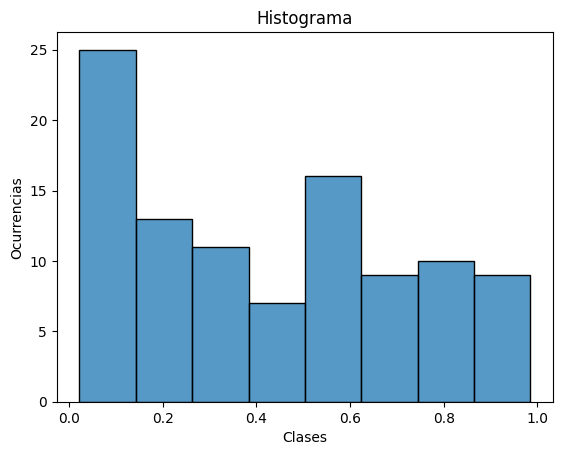

Limite superior: 12.59 
Estadistico: 18.56 
Se rechaza la hipótesis nula


In [130]:
# Creamos histograma y obtenemos las frecuencias de cada clase
hist = plot_histograma(muestra1)
frec = obtener_frecuencias(hist)

# Aplicamos test Chi2
test_chi2(frec)

#### Muestra 2 (n = 1000)

Limite superior: 12.59 
Estadistico: 2.43 
Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).


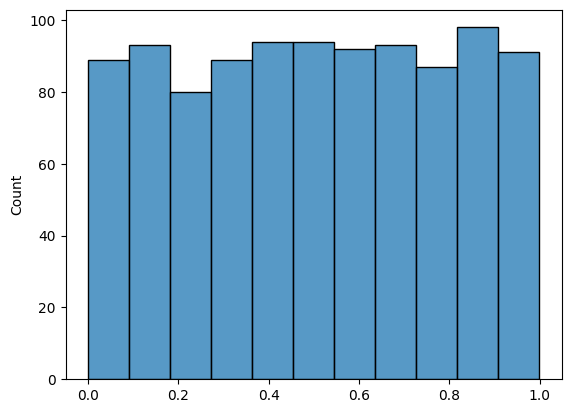

In [128]:
# Creamos histograma y obtenemos las frecuencias de cada clase
hist = sns.histplot(data=muestra2)
frec = obtener_frecuencias(hist)

# Aplicamos test Chi2
test_chi2(frec)

Probamos con un número más grande de bins: 50

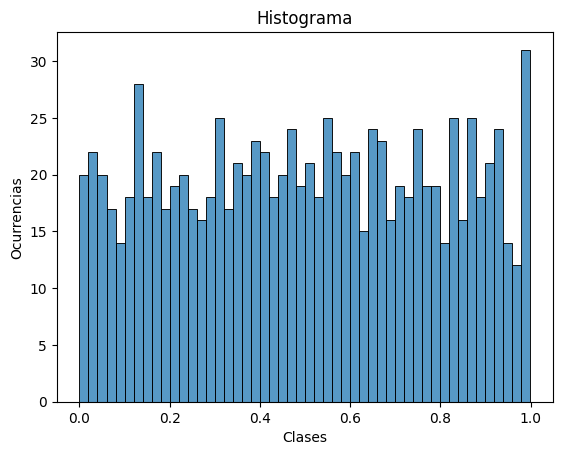

Limite superior: 12.59 
Estadistico: 35.20 
Se rechaza la hipótesis nula


In [134]:
# Creamos histograma y obtenemos las frecuencias de cada clase
hist = plot_histograma(muestra2, 50)
frec = obtener_frecuencias(hist)

# Aplicamos test Chi2
test_chi2(frec)

#### Muestra 3 (n = 100000)

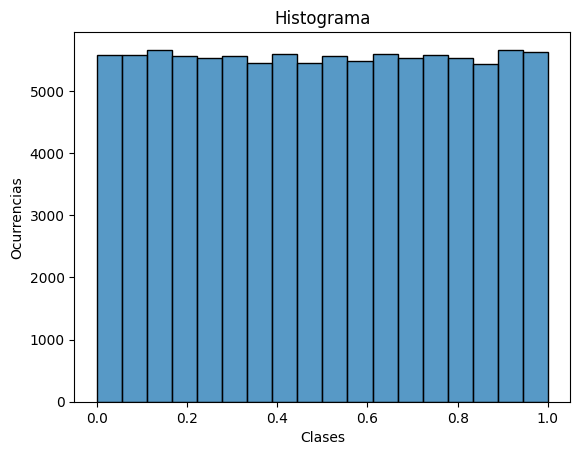

Limite superior: 12.59 
Estadistico: 13.48 
Se rechaza la hipótesis nula


In [135]:
# Creamos histograma y obtenemos las frecuencias de cada clase
hist = plot_histograma(muestra3)
frec = obtener_frecuencias(hist

# Aplicamos test Chi2
test_chi2(frec)

Probamos con un número más grande de bins: 100

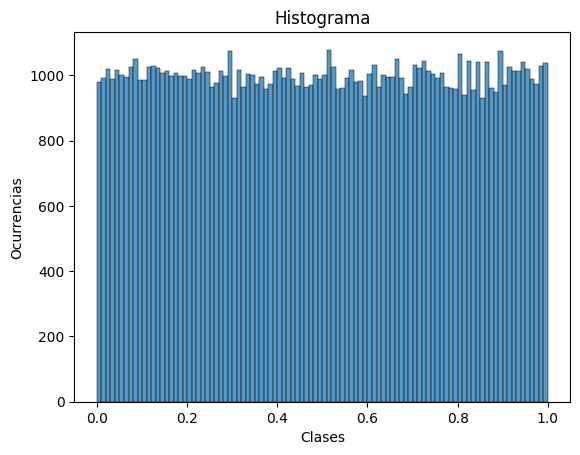

Limite superior: 123.23 
Estadistico: 100.04 
Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).


In [139]:
# Creamos histograma y obtenemos las frecuencias de cada clase
hist = plot_histograma(muestra3, 100)
frec = obtener_frecuencias(hist)

# Aplicamos test Chi2
test_chi2(frec)

#### Resultados

Una vez realizados los tests, analicemos los resultados. En primer lugar notamos que son coherentes ya que a medida que incrementamos el tamaño de la muestra, ésta tiende a una distribución uniforme, lo cual concuerda con lo esperado.

Además, podemos ver que para la única muestra que se rechazó la hipotesis nula es la de tamaño 100, mientras que para las muestras de tamaño 1000 y 100000 no habia evidencia suficiente para rechazarla.

### Test Kolmogorov-Smirnov

En primer lugar vamos a visualizar un grafico comparando la función de distribución acumulada (CDF) de una uniforme (0,1) con la función de distribución acumulada empírica (ECDF) construida a partir de la muestra obtenida. Posteriormente, aplicaremos el test de Kolmogorov-Smirnov, donde la hipotesis nula será que nuestra muestra presenta una distribución uniforme.

A continuación se encuentran una serie de funciones que serán de utilidad a lo largo del test.

In [155]:
# Grafica las funciones ECFD y CFD
def plot_ecfd_vs_cfd(muestra):
    plt.figure()
    sns.ecdfplot(data=muestra, label='ECDF')
    uniform_data = np.linspace(0,1,len(muestra))
    plt.plot(np.sort(uniform_data), np.linspace(0, 1, len(uniform_data), endpoint=False), color='r', label='CDF')

    plt.legend(title="Funciones")
    plt.ylabel("F(x)")
    plt.xlabel("x")
    plt.title('ECDF vs CDF')
    plt.show()
    

# Test Kolmogorov-Smirnov
def test_kolmogorov_smirnov(muestra):
    estadistico_ks, pvalor_ks= kstest(muestra, 'uniform')
    print("KS = %f, pValor = %f" % (estadistico_ks, pvalor_ks))

    if pvalor_ks < 0.05:
        print("Se rechaza la hipótesis nula")
    else:
        print("Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).")

#### Muestra 1 (n = 100)

In [87]:
test_kolmogorov_smirnov(muestra1)

KS = 0.135139, pValor = 0.047046
Se rechaza la hipótesis nula


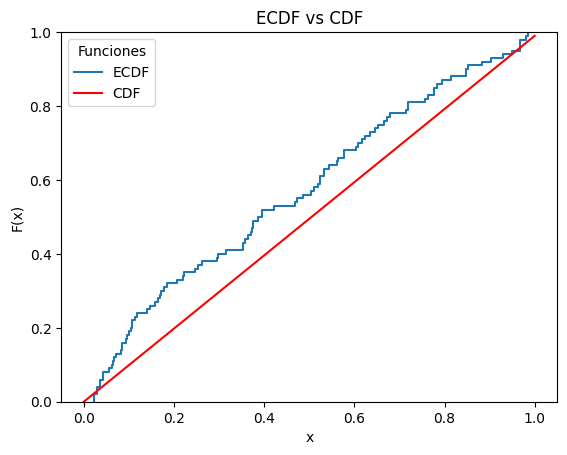

In [75]:
plot_ecfd_vs_cfd(muestra1)

#### Muestra 2 (n = 1000)

In [88]:
test_kolmogorov_smirnov(muestra2)

KS = 0.014628, pValor = 0.980950
Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).


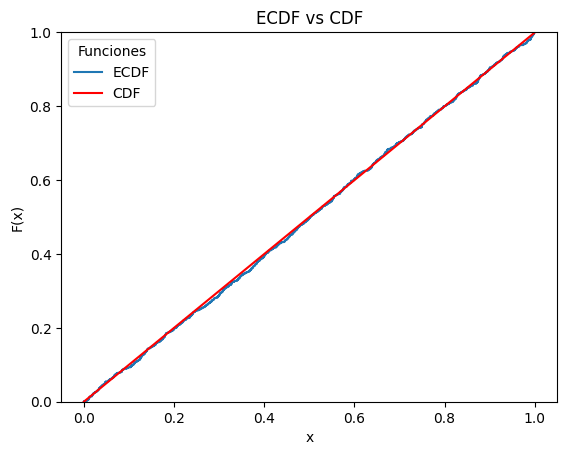

In [76]:
plot_ecfd_vs_cfd(muestra2)

#### Muestra 3 (n = 100000)

In [89]:
test_kolmogorov_smirnov(muestra3)

KS = 0.002283, pValor = 0.673697
Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).


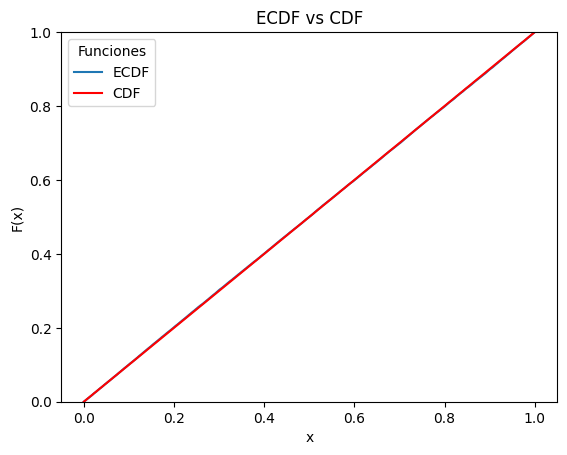

In [77]:
plot_ecfd_vs_cfd(muestra3)

#### Resultados

Similar al test anterior, para la muestra pequeña (n = 100) se rechazó la hipotesis nula. Sin embargo, para las dos siguientes muestras (n=1000 y n=100000), no hay evidencia suficiente para considerar que no siguen una distribución uniforme.

A su vez, comparando las funciones de distribución acumulada real vs empírica, vemos claramente cómo a medida que aumentamos el tamaño de nuestra muestra, la función empírica comienza a parecerse cada vez más a la funcion de distribución real, de modo que para la muestra de n=100000 son casi coincidentes.

### Test QQ Plot

Usaremos QQ Plot para poder comparar gráficamente los cuantiles teóricos correspondientes a una distribución uniforme y los cuantiles que se obtienen a partir de nuestras muestras. Vamos a buscar la mayor coincidencia posible, por lo tanto, el caso ideal es que ambos cuantiles coincidan formándose así una diagonal donde x=y

In [150]:
# Grafica el QQ Plot
def qq_plot(muestra):
    sm.qqplot(data=np.array(muestra), dist=distributions.uniform, line ='45')
    
    plt.title('QQ Plot - Distribución uniforme')
    plt.show()

#### Muestra 1 (n = 100)

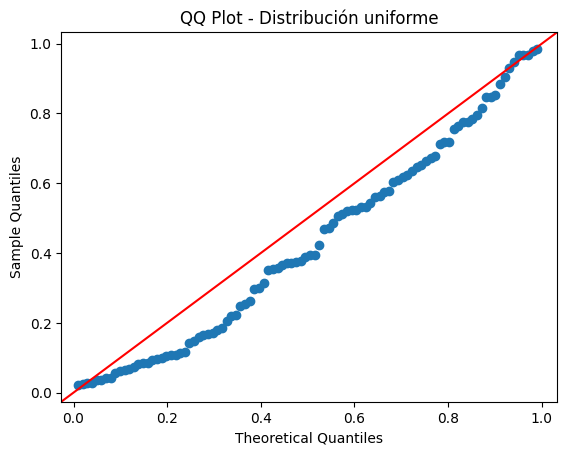

In [151]:
qq_plot(muestra1)

#### Muestra 2 (n = 1000)

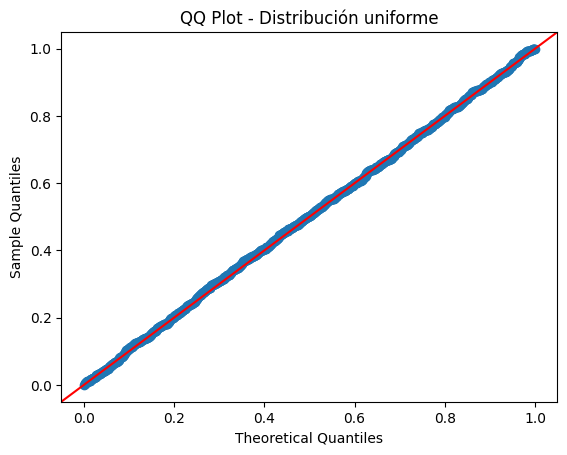

In [152]:
qq_plot(muestra2)

#### Muestra 3 (n = 100000)

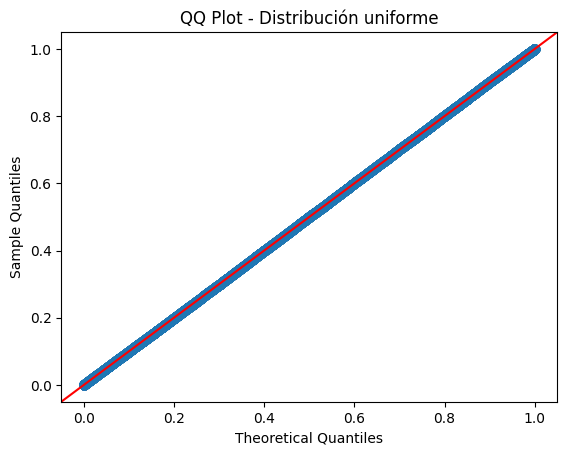

In [153]:
qq_plot(muestra3)

#### Resultados

Nuevamente, vemos que con la muestra pequeña, los cuantiles de la muestra distan bastante de los cuantiles teóricos, de modo que podriamos rechazar nuestra hipótesis nula (la muestra sigue una distribución uniforme).

Sin embargo, al pasar a una muestra de tamaño 1000 ya se notan grandes cambios favorables dado a que ambos cuantiles son relativamente similares. Por último, con la muestra de tamaño 100000, vemos una coincidencia mucho más precisa entre los dos cuantiles formándose una diagonal practicamente recta. En base a estos gráficos, podríamos decir que para las muestras de n=1000 y n=100000 no hay evidencia suficiente para rechazar nuestra hipótesis nula.